In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!gdown --id 1L843daxmFSZD_hyz_AMIQ6-dzTPDaoGJ

Downloading...
From: https://drive.google.com/uc?id=1L843daxmFSZD_hyz_AMIQ6-dzTPDaoGJ
To: /content/font_fam-20220209T082332Z-001.zip
100% 86.7M/86.7M [00:00<00:00, 259MB/s]


In [3]:
!unzip --qq "/content/font_fam-20220209T082332Z-001.zip" -d"/content/data/"

In [2]:
!gdown https://drive.google.com/uc?id=1wwAIAIlWwCVcH09uyvq5GU28too1cQZo

Downloading...
From: https://drive.google.com/uc?id=1wwAIAIlWwCVcH09uyvq5GU28too1cQZo
To: /content/test_png.zip
100% 193M/193M [00:00<00:00, 208MB/s]


In [3]:
!unzip --qq "/content/test_png.zip" -d"/content/testdata/"

In [4]:
ls "/content/drive/MyDrive/Machima/MiniHackathon-Week1-FontRecogition/font_recognition/train/font_fam/"

 Angsana_New/                fonttintin/        TH_Mali_Grade6/
 CORDIA/                     Kunlasatri/        THSarabun/
'DM_Shining Star_Regular'/   TH_Chakra_Petch/
 FC_Knomphing_Regular/       TH_Charm_of_AU/


In [5]:
#path_data = "/content/drive/MyDrive/Machima/MiniHackathon-Week1-FontRecogition/font_recognition/train/font_fam/"
path_data = "/content/data/font_fam/"

In [4]:
from matplotlib.pyplot import imshow
import matplotlib.cm as cm
import matplotlib.pylab as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import PIL
from PIL import ImageFilter
import cv2
import itertools
import random
import keras
import imutils
from imutils import paths
import os
from keras import optimizers
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras import callbacks
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D , UpSampling2D ,Conv2DTranspose
from keras import backend as K

from tqdm import tqdm

%matplotlib inline

In [7]:
def pil_image(img_path):
    pil_im =PIL.Image.open(img_path).convert('L')
    pil_im=pil_im.resize((105,105))
    #imshow(np.asarray(pil_im))
    return pil_im

# Augumentation Steps 
1) Noise
2) Blur
3) Perpective Rotation
4) Shading
5) Variable Character Spacing
6) Variable Aspect Ratio

In [8]:
def noise_image(pil_im):
    # Adding Noise to image
    img_array = np.asarray(pil_im)
    mean = 0.0   # some constant
    std = 5   # some constant (standard deviation)
    noisy_img = img_array + np.random.normal(mean, std, img_array.shape)
    noisy_img_clipped = np.clip(noisy_img, 0, 255)
    noise_img = PIL.Image.fromarray(np.uint8(noisy_img_clipped)) # output
    #imshow((noisy_img_clipped ).astype(np.uint8))
    noise_img=noise_img.resize((105,105))
    return noise_img

In [9]:
def blur_image(pil_im):
    #Adding Blur to image 
    blur_img = pil_im.filter(ImageFilter.GaussianBlur(radius=3)) # ouput
    #imshow(blur_img)
    blur_img=blur_img.resize((105,105))
    return blur_img

In [10]:
def affine_rotation(img):
    
    #img=cv2.imread(img_path,0)
    rows, columns = img.shape

    point1 = np.float32([[10, 10], [30, 10], [10, 30]])
    point2 = np.float32([[20, 15], [40, 10], [20, 40]])

    A = cv2.getAffineTransform(point1, point2)

    output = cv2.warpAffine(img, A, (columns, rows))
    affine_img = PIL.Image.fromarray(np.uint8(output)) # affine rotated output
    #imshow(output)
    affine_img=affine_img.resize((105,105))
    return affine_img
   

In [11]:
def gradient_fill(image):
    #image=cv2.imread(img_path,0)
    laplacian = cv2.Laplacian(image,cv2.CV_64F)
    laplacian = cv2.resize(laplacian, (105, 105))
    return laplacian

## Preparing Dataset

In [12]:
data_path = "/content/data/font_fam/"
data=[]
labels=[]
imagePaths = sorted(list(paths.list_images(data_path)))
random.seed(42)
random.shuffle(imagePaths)

In [13]:
def conv_label(label):
  italic = label.find("italic")
  bold = label.find("bold")
  #print(label)
  #print(italic)
  #print(bold)
  if italic <0 and bold <0:
    return 0
  elif italic >0 and bold <0:
    return 1
  elif italic <0 and bold >0:
    return 2
  elif italic >0 and bold >0:
    return 3


In [14]:
conv_label(imagePaths[3])

0

In [15]:
augument=["blur","noise","affine","gradient"]
a=itertools.combinations(augument, 4)

for i in list(a): 
    print(list(i))

['blur', 'noise', 'affine', 'gradient']


In [16]:
counter=0
for imagePath in tqdm(imagePaths[:30000]):
    #label = imagePath.split(os.path.sep)[-2]
    label = conv_label(imagePath)
    #print(imagePath)
    #print(label)
    #print("-----")
    pil_img = pil_image(imagePath)
    #imshow(pil_img)
    
    # Adding original image
    org_img = img_to_array(pil_img)
    #print(org_img.shape)
    data.append(org_img)
    labels.append(label)
    
    # augument=["noise","blur","affine","gradient"]
    # for l in range(0,len(augument)):
    
    #     a=itertools.combinations(augument, l+1)

    #     for i in list(a): 
    #         combinations=list(i)
    #         #print(len(combinations))
    #         temp_img = pil_img
    #         for j in combinations:
            
    #             if j == 'noise':
    #                 # Adding Noise image
    #                 temp_img = noise_image(temp_img)
                    
    #             elif j == 'blur':
    #                 # Adding Blur image
    #                 temp_img = blur_image(temp_img)
    #                 #imshow(blur_img)
                    
    
    #             elif j == 'affine':
    #                 open_cv_affine = np.array(pil_img)
    #                 # Adding affine rotation image
    #                 temp_img = affine_rotation(open_cv_affine)

    #             elif j == 'gradient':
    #                 open_cv_gradient = np.array(pil_img)
    #                 # Adding gradient image
    #                 temp_img = gradient_fill(open_cv_gradient)
  
    #         temp_img = img_to_array(temp_img)
    #         data.append(temp_img)
    #         labels.append(label)

100%|██████████| 30000/30000 [00:14<00:00, 2075.13it/s]


In [17]:
mylist = list(dict.fromkeys(labels))
#len(mylist)
mylist

[3, 1, 0, 2]

In [18]:
data = np.asarray(data, dtype="float") / 255.0
labels = np.array(labels)
print("Success")
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)

Success


In [19]:

mylist = list(dict.fromkeys(trainY))
#len(mylist)
mylist

[2, 3, 0, 1]

In [20]:
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=4)
testY = to_categorical(testY, num_classes=4)

In [21]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,horizontal_flip=True)

In [22]:
#K.set_image_dim_ordering('tf')

K.set_image_data_format('channels_last')

In [23]:
 def create_model():
  model=Sequential()

  # Cu Layers 
  model.add(Conv2D(64, kernel_size=(48, 48), activation='relu', input_shape=(105,105,1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, kernel_size=(24, 24), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2DTranspose(128, (24,24), strides = (2,2), activation = 'relu', padding='same', kernel_initializer='uniform'))
  model.add(UpSampling2D(size=(2, 2)))

  model.add(Conv2DTranspose(64, (12,12), strides = (2,2), activation = 'relu', padding='same', kernel_initializer='uniform'))
  model.add(UpSampling2D(size=(2, 2)))

  #Cs Layers
  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

  model.add(Conv2D(256, kernel_size=(12, 12), activation='relu'))

  model.add(Flatten())

  model.add(Dense(4096, activation='relu'))

  model.add(Dropout(0.5))

  model.add(Dense(4096,activation='relu'))

  model.add(Dropout(0.5))

  model.add(Dense(2383,activation='relu'))

  model.add(Dense(4, activation='softmax'))
 
  return model

In [24]:
import tensorflow as tf

batch_size = 128
epochs = 50
model= create_model()
sgd = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

#sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [25]:
early_stopping=callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')

path_s = "/content/drive/MyDrive/30 อบรม superAI2/31 แข่งขัน/01 font recognition/train_model/"
filepath= path_s + "top_model_4class.h5"

checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [early_stopping,checkpoint]

In [26]:
model.fit(trainX, trainY,shuffle=True,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(testX, testY),callbacks=callbacks_list)

Epoch 1/50
176/176 [==============================] - ETA: 0s - loss: 1.3698 - accuracy: 0.3032
Epoch 00001: val_loss improved from inf to 1.37689, saving model to /content/drive/MyDrive/30 อบรม superAI2/31 แข่งขัน/01 font recognition/train_model/top_model_4class.h5
176/176 [==============================] - 144s 725ms/step - loss: 1.3698 - accuracy: 0.3032 - val_loss: 1.3769 - val_accuracy: 0.3004
Epoch 2/50
176/176 [==============================] - ETA: 0s - loss: 1.3064 - accuracy: 0.3649
Epoch 00002: val_loss did not improve from 1.37689
176/176 [==============================] - 50s 284ms/step - loss: 1.3064 - accuracy: 0.3649 - val_loss: 4.0571 - val_accuracy: 0.2496
Epoch 3/50
176/176 [==============================] - ETA: 0s - loss: 1.1300 - accuracy: 0.4912
Epoch 00003: val_loss did not improve from 1.37689
176/176 [==============================] - 49s 280ms/step - loss: 1.1300 - accuracy: 0.4912 - val_loss: 14.9090 - val_accuracy: 0.3016
Epoch 4/50
176/176 [===============

In [27]:
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.971069097518921
Test accuracy: 0.602400004863739


In [28]:
from keras.models import load_model
path_s = "/content/drive/MyDrive/30 อบรม superAI2/31 แข่งขัน/01 font recognition/train_model/"
#model = load_model(path_s + "top_model_4class.h5")

model = load_model("/content/drive/MyDrive/30 อบรม superAI2/31 แข่งขัน/01 font recognition/train_model/top_model_4class.h5")

In [29]:
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0479977130889893
Test accuracy: 0.6945333480834961


In [30]:
!pwd

/content


In [45]:
import PIL
from PIL import ImageFilter
from keras.preprocessing.image import img_to_array
import numpy as np
import PIL
import matplotlib.cm as cm
import matplotlib.pylab as plt

def blur_image(pil_im):
    #Adding Blur to image 
    blur_img = pil_im.filter(ImageFilter.GaussianBlur(radius=3)) # ouput
    #imshow(blur_img)
    blur_img=blur_img.resize((105,105))
    return blur_img

def pil_image(pil_im):
    pil_im=pil_im.resize((105,105))
    #imshow(np.asarray(pil_im))
    return pil_im

#img_path="/content/data/font_fam/fonttintin/10080052_fonttintin_12px_normal_bold.png"
#img_path="/content/data/font_fam/Angsana_New/1012c54c_Angsana_New_16px_italic_bold.png"
img_path="/content/data/font_fam/THSarabun/10019de9_TH_Sarabun_14px_normal_bold.png"

pil_im =PIL.Image.open(img_path).convert('L')
pil_im=pil_image(pil_im)
org_img = img_to_array(pil_im)



In [54]:
def rev_conv_label(label):
    if label == 0:
        return 'Normal Normal'
    elif label == 1:
        return 'Italic Normal'
    elif label == 2:
        return 'Normal Bold'
    elif label == 3:
        return 'Italic Bold'

In [47]:
data=[]
data.append(org_img)
data = np.asarray(data, dtype="float") / 255.0

In [48]:
# y = model.predict_classes(data)

y = model.predict(data)
y = np.round(y).astype(int)

In [49]:
y[0]

array([0, 0, 1, 0])

In [50]:
np.argmax(y[0])

2

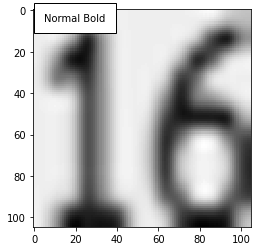

In [55]:
label = rev_conv_label(np.argmax(y[0]))
fig, ax = plt.subplots(1)
ax.imshow(pil_im, interpolation='nearest', cmap=cm.gray)
ax.text(5, 5, label , bbox={'facecolor': 'white', 'pad': 10})
plt.show()

In [5]:
from keras.models import load_model
path_s = "/content/drive/MyDrive/30 อบรม superAI2/31 แข่งขัน/01 font recognition/train_model/"
#model = load_model(path_s + "top_model_4class.h5")

model = load_model("/content/drive/MyDrive/30 อบรม superAI2/31 แข่งขัน/01 font recognition/train_model/top_model_4class.h5")

In [36]:
def rev_conv_label(label):
    if label == 0:
        return 'normal-normal'
    elif label == 1:
        return 'italic-normal'
    elif label == 2:
        return 'normal-bold'
    elif label == 3:
        return 'italic-bold'

## Preparing Dataset

In [6]:
data_path_test = "/content/testdata/content/crop_test_to_png/"
data_test=[]
#labels_test=[]
imagePaths_test = sorted(list(paths.list_images(data_path_test)))

In [7]:
counter=0
for imagePath in tqdm(imagePaths_test):
  pil_im =PIL.Image.open(imagePath).convert('L')
  pil_im=pil_im.resize((105,105))
  org_img = img_to_array(pil_im)
  data_test.append(org_img)
  

100%|██████████| 48251/48251 [00:32<00:00, 1462.66it/s]


In [8]:
data_test = np.asarray(data_test, dtype="float") / 255.0

In [9]:
y = model.predict(data_test)
y = np.round(y).astype(int)

In [18]:
y

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0]])

In [16]:
yp = np.argmax(y)

In [21]:
yp

3

In [23]:
from numpy import argmax
#summed = np.sum(y, axis=0)
# argmax across classes
result5 = argmax(y, axis=1)

In [24]:
result5

array([3, 2, 1, ..., 2, 0, 2])

In [ ]:
from tqdm import tqdm
import os
name_file = []
for root, dirs, files in tqdm(os.walk("/content/content/crop_test_to_png")):
    for file in files:
        if file.endswith(".png"):
#              print(os.path.join(root, file))
             name_file.append(os.path.join(root, file))

In [11]:
print(imagePaths_test)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
import pandas as pd
result = pd.DataFrame({'nameFile': imagePaths_test})
result

,nameFile
0,/content/testdata/content/crop_test_to_png/000...
1,/content/testdata/content/crop_test_to_png/000...
2,/content/testdata/content/crop_test_to_png/000...
3,/content/testdata/content/crop_test_to_png/000...
4,/content/testdata/content/crop_test_to_png/000...
...,...
48246,/content/testdata/content/crop_test_to_png/fff...
48247,/content/testdata/content/crop_test_to_png/fff...
48248,/content/testdata/content/crop_test_to_png/fff...
48249,/content/testdata/content/crop_test_to_png/fff...


In [14]:
def remove_word(text):
  text = text.replace('/content/testdata/content/crop_test_to_png/','')
  text = text.replace('.png','')
  return text
result['Id'] = result['nameFile'][:].apply(remove_word)
result

,nameFile,Id
0,/content/testdata/content/crop_test_to_png/000...,0000144b
1,/content/testdata/content/crop_test_to_png/000...,00013eaf
2,/content/testdata/content/crop_test_to_png/000...,00024a7a
3,/content/testdata/content/crop_test_to_png/000...,0004eae6
4,/content/testdata/content/crop_test_to_png/000...,00066fea
...,...,...
48246,/content/testdata/content/crop_test_to_png/fff...,fffb9abb
48247,/content/testdata/content/crop_test_to_png/fff...,fffbbe56
48248,/content/testdata/content/crop_test_to_png/fff...,fffbcbaf
48249,/content/testdata/content/crop_test_to_png/fff...,fffc5245


In [28]:
result['pred'] = result5

In [29]:
result

,nameFile,Id,pred
0,/content/testdata/content/crop_test_to_png/000...,0000144b,3
1,/content/testdata/content/crop_test_to_png/000...,00013eaf,2
2,/content/testdata/content/crop_test_to_png/000...,00024a7a,1
3,/content/testdata/content/crop_test_to_png/000...,0004eae6,0
4,/content/testdata/content/crop_test_to_png/000...,00066fea,1
...,...,...,...
48246,/content/testdata/content/crop_test_to_png/fff...,fffb9abb,1
48247,/content/testdata/content/crop_test_to_png/fff...,fffbbe56,0
48248,/content/testdata/content/crop_test_to_png/fff...,fffbcbaf,2
48249,/content/testdata/content/crop_test_to_png/fff...,fffc5245,0


In [33]:
result['pred'][1]

2

In [40]:
result['Predicted'] = result['pred'][:].apply(rev_conv_label)

italic-bold


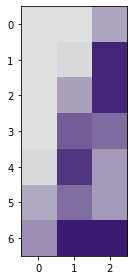

normal-bold


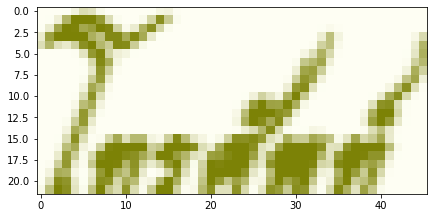

italic-normal


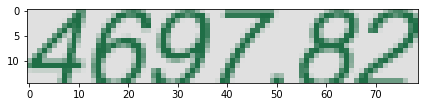

normal-normal


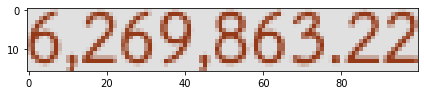

italic-normal


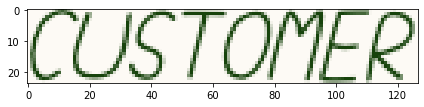

normal-bold


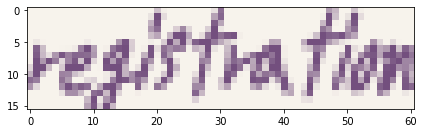

normal-normal


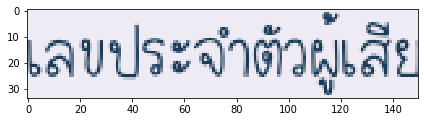

normal-normal


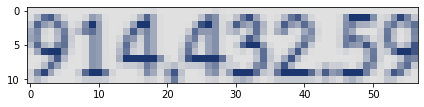

italic-normal


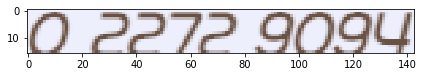

italic-normal


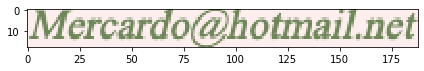

normal-bold


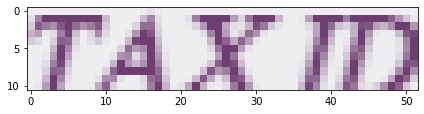

normal-normal


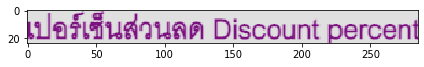

italic-normal


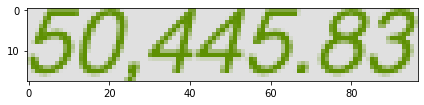

normal-normal


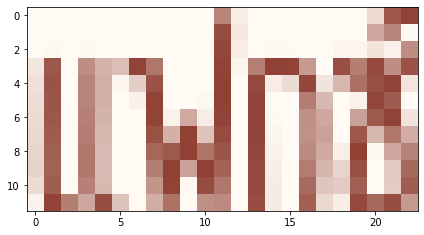

normal-normal


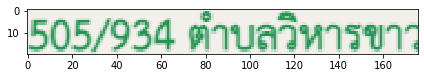

italic-bold


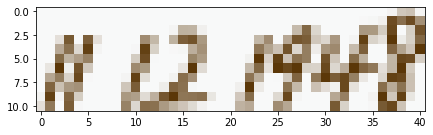

normal-normal


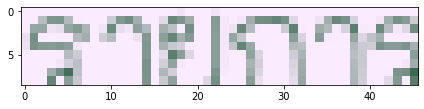

italic-bold


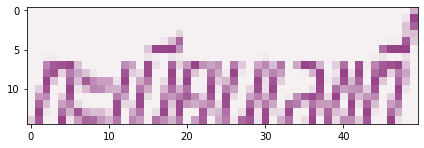

normal-bold


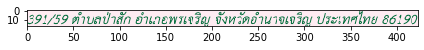

normal-bold


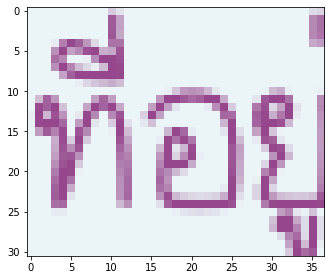

In [41]:
from skimage import io
for i in range(20):
  #print(rev_conv_label(result['Predicted'][i]))
  print(result['Predicted'][i])
  img = io.imread(result['nameFile'][i])
  io.imshow(img)
  io.show()

In [42]:
answer = result[["Id","Predicted"]]

In [43]:
answer

,Id,Predicted
0,0000144b,italic-bold
1,00013eaf,normal-bold
2,00024a7a,italic-normal
3,0004eae6,normal-normal
4,00066fea,italic-normal
...,...,...
48246,fffb9abb,italic-normal
48247,fffbbe56,normal-normal
48248,fffbcbaf,normal-bold
48249,fffc5245,normal-normal


In [44]:
answer.to_csv('task_predcit_italic.csv', index=False)